# Attempt for Genetic Algorithms 
Solving the colored travelling salesman problem for the Kaggle Santa 2021 - The Merry Movie Montage competition. 

Approach inspired by: *Li, Jun & Sun, Qirui & Zhou, Mengchu & Xiaolong, yu. (2014). Colored Traveling Salesman Problem and Solution. IFAC Proceedings Volumes (IFAC-PapersOnline). 19.*

In [2]:
import pandas as pd
import numpy as np
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from itertools import permutations 
from functools import reduce

## Problem Statement

We have 3 elfs who want to watch all possible ordering of $n$ films. They've agreed to distribute the load, but all 3 want to watch films starting 🎅🤶.

Suppose we have 3 salesmen and $k$ cities, where $k$ is the total number of permutations that must all be visited $n!$ (5040 for $n$=7) they also want to watch all films starting with 🎅🤶 which accounts for $(n-2)!$ of these cities (120 or $n$=7).

The distance between a city, is how much its permutation increases the total length of a string, assuming you can overlap the next city onto the end of the current. Inspired from [here](https://www.kaggle.com/c/santa-2021/discussion/288995)

**Note**: this is not symmetric

Examples: 


| City | Permutation |
| ---- | ----------- |
| 1 |🤶🎀🎁🎄🧝🦌🎅|
| 2 |🎅🤶🦌🧝🎀🎁🎄|
| 3 |🎀🎁🎄🧝🦌🎅🤶|

Distance(1->2) = 6
Since they overlap on the santa:

🤶🎀🎁🎄🧝🦌🎅

- - - - -🎅🤶🦌🧝🎀🎁🎄


But Distance(2->1) = 7 since theres no overlap

🎅🤶🦌🧝🎀🎁🎄

- - - - - 🤶🎀🎁🎄🧝🦌🎅

 
And the best overlap possible would be Distance(1->3) = 1 since we can align up to the bow

🤶🎀🎁🎄🧝🦌🎅

- 🎀🎁🎄🧝🦌🎅🤶

So, we create a complete directional graph, $G=(V,E)$ where verticies are the number of cities $V=0,...,k-1$, and each edge $(i,j)\in E, i\neq j$ is associated with a weight $w_{ij}$ representing the distance between the two cities $i$ and $j$. 

$V$ is divided into $3+1$ disjoint nonempty sets, i.e. a shared city set $U$, and exclusive ones to each elf $V_i, \forall i \in {1,2,3}$. 

We assign each salesman $i$ with color $i. \forall a \in U$ its color set. 

CTSP Objective: Determine $3$ Hamiltonian cycles over $G$ with least tour cost. Where any vertex of each exclusive set must be visited exactly once by a specified salesman and any vertex of the shared set must be visited by a salesman exactly once. 

**NOTE: TSP creates a Hamiltonian cycle, however we do not care about distance between node k-1 back to 0 so might have to create some kind of dummy node of distance 0 back to origin???**

## Genetic Algorithm Set Up
Represent a solution of CTSP using *dual chromosomes* that are decimally coded. i.e. city and salesman chromosomes with individual length being $k-1$. The depot for all chromosomes is not coded in and is added into the final solution.

The first chromosome has a permutation of $k-1$ cities, while the second assigns a salesman to each of the shared and exclusive cities in the corresponding position of the first:

Example coding of $k=10$ for 3 salesman:

| Chromosome | |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |2|10|8|9|5|4|7|1|3|6|
| Salesman||1|2|1|3|3|2|1|1|2|3|

Given a generation, a city can only appear exactly once in an individual. 
So genes 1 and 2 in the city are exclusive for salesman 1, genes 3 and 4 for salesman 2, and 5 and 6 for salesman 3. 
Shared cities are genes 7-10 which can be assigned to any salesman. 

<div class="alert alert-block alert-danger">
<b>So in our case:</b> We create permutations starting with 🎅🤶 as exclusive to each salesman (so duplicate their occurance, and pre-assign) 
Then the rest are shared cities which can be allocated to any salesman. 
    
Future work: includes Kyras allocation of 'cycle groups'
</div>

----------------
## City Crossover and Mutation (CCM)
### City Crossover 

Two segments with the same range are selected at random from two city individuals of the given parents, and then the two segments are swapped, thereby resulting in new indivudals. 
Second, replace the redundant genes outside the segments in the two city chromosomes by ones meeting the gene swapping relationship between two mentioned segments until no redundent gene remains. Finally, check if each exclusive city is assigned to a correct salesman and correct wrong assignments if any. 

**Example:**

3 Salesmen, 10 Nodes, 

| Salesman | Exclusive City|
| ---- | -- |
|1| 1,2|
|2|3,4|
|3|5,6|
|U|7,8,9,10|


*Step 1:* The crossover segments (bolded) are selected in the two city chromosomes and then their genes are the same positions are swapped one by one. 

| Chromosome 1| |  ||||||||||| Chromosome 2| |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- || ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |2|10|**8**|**9**|**5**|**4**|**7**|**1**|3|6|| City | |5|9|**3**|**8**|**2**|**7**|**1**|**10**|6|4|
| Salesman||1|2|1|3|3|2|2|1|2|3|| Salesman||3|2|2|3|1|1|1|1|3|2|


*Step 2:* The swapping results in two new individuals. The swapping relationship is: 8-3, 9-8, 5-2, 4-7, 1-10. 


| Chromosome 1| |  ||||||||||| Chromosome 2| |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- || ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |2|10|**3**|**8**|**2**|**7**|**1**|**10**|3|6|| City | |5|9|**8**|**9**|**5**|**4**|**7**|**1**|6|4|
| Salesman||1|2|1|3|3|2|2|1|2|3|| Salesman||3|2|2|3|1|1|1|1|3|2|


*Step 3:*  Following this swapping relationship, the redundant genes outside the two segments are replaced stepwise till no redundant gene is found. For example, the repeated gene 3 at the second last position of the left city should be replaced by 8 according to the swapping relationship 8-3 from step 1. However, after replacement, new gene 8 is still repetitive and has to be replaced again by gene 9 according to the swapping relationship 9-8.   

| Chromosome 1| |  ||||||||||| Chromosome 2| |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- || ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |5|4|**3**|**8**|**2**|**7**|**1**|**10**|9|6|| City | |2|3|**8**|**9**|**5**|**4**|**7**|**1**|6|10|
| Salesman||**1**|2|**1**|3|3|2|2|1|2|**3**|| Salesman||**3**|2|2|3|**1**|**1**|1|1|3|2|

Step 4: The resultant exclusive cities 5,3,7,1,6 in the left chromosome and cities 2,5,4 in the right are assigned to the wrong salesmen so reassign them to the correct salesment and result in two feasible individuals. 

| Chromosome 1| |  ||||||||||| Chromosome 2| |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- || ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |5|4|**3**|**8**|**2**|**7**|**1**|**10**|9|6|| City | |2|3|**8**|**9**|**5**|**4**|**7**|**1**|6|10|
| Salesman||3|2|2|3|1|2|1|1|2|3|| Salesman||1|2|2|3|3|2|1|1|3|2|

----------------
### City Mutation (CM)
A city mutation process of a dual-chromosome includes two steps: i.e.
1. First, a pair of genes in a city chromosome are selected for swapping, and 
2. if needed, correct the two corresponding genes in the salesman chromosome following the city-salesman matching relationship. 

Below shows a crossover process of a dual-chromosome with a single crossover of city chromosomes. 

| Chromosome | |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |5|9|3|**8**|2|**7**|1|10|6|4|
| Salesman||3|2|2|3|1|1|1|1|3|2|

Genes 8 and 7 are selected and swapped. They are shared cities and can be assigned to any salesman. Therefore the city-salesman relationship is satisfied and mutation is over.

Swap:

| Chromosome | |  ||||||||||
| ---- | -- |-- |-- |-- |-- |-- |-- |-- |-- |-- |-- |
| City | |5|9|3|**7**|2|**8**|1|10|6|4|
| Salesman||3|2|2|3|1|1|1|1|3|2|


----------------
### Fitness Function

We wish to minimise the maximum of the total length of the three elves permutations (their routes along our permutation cities).

________

The process of GA consists of selection, CCM and fitness calculation. 

In [13]:
# Create function to calculate distance between two strings
def calculateDistance(string1, string2):
    #take string 1:   1234567
    #string 2.   :       4567312
    #distance = 3 
    # note we're doing asymetric so 
    #string1:   4567312
    #string2:        1234567
    #distance = 5
    res = reduce(lambda i, j: i + j[next(idx 
                for idx in reversed(range(len(j) + 1)) 
                if i.endswith(j[:idx])):], [string1, string2], '', )
    return len(res)-len(string1)

In [14]:
def checkOutputValid(outputs, n):
    # outputs = array of the 3 outputs 
    # n = number of films (e.g. 4)
    total_permutations = [''.join([str(i) for i in j]) for j in list(permutations(range(1,n+1)))]
    compulsory = ['12'+''.join([str(i) for i in j]) for j in list(permutations(range(3,n+1)))]
    seen = set()
    output_num = 0 
    for output in outputs:
        output_num+=1
        # check there is 2 or less occurances of wildcard (8)
        if output.count('8')>2:
            print('Not valid - too many wild cards')
            return False
        # check it contains 12xxx
        # but also account for wildcard possibility... 
        # duplicate compulsory and replace with possible 8 in positions?
        for comp in compulsory:
            if comp not in output:
                # doesnt exist as '1234' but now look at wild cards (i.e. if 8234, 1834...) in it
                wild_c = [comp[:i-1] + '8' + comp[i:] for i in range(1, n+1)]
                exists = any([c in output for c in wild_c])
                if not exists:
                    print('Not valid - string {} doesnt contain value '.format(output_num), comp)
                    return False

        # Now check every permutation exists (also have to handle wildcards)
        for i in range(len(output) - n + 1):
            perm = output[i:i+n] # get permutation (e.g. 3412)

            if '8' in perm: #check if contains wildcard
                wild_perm = [perm.replace('8', str(i)) for i in range(1,n+1)]
                seen.update(wild_perm)
            else:
                seen.add(perm)
                

    if set(total_permutations) <= seen:
        # seen contains all the permutations
        print('Valid Output!')
        scores = [len(output) for output in outputs]
        print('Lengths: ', scores)
        print('Score: ', max(scores))
        return True
    
    print('Not valid output - doesnt contain all permutations')
    missing = set(total_permutations).difference(seen)
    print('Missing {} values, Missing:'.format(len(missing)), missing)
    return False

## Testing for n=4

In [15]:
perms=list(permutations([1,2,3,4],4))
perms = [''.join([str(i) for i in j]) for j in perms]
perms

['1234',
 '1243',
 '1324',
 '1342',
 '1423',
 '1432',
 '2134',
 '2143',
 '2314',
 '2341',
 '2413',
 '2431',
 '3124',
 '3142',
 '3214',
 '3241',
 '3412',
 '3421',
 '4123',
 '4132',
 '4213',
 '4231',
 '4312',
 '4321']

In [114]:
# Convert our permutations into a dataframe that stores:
#'city number', permutation, and salesman that should visit it (0,1,2 or -1 if any)
# We need to duplicate 12xxx films and add those on 
compulsory = ['12'+''.join([str(i) for i in j]) for j in list(permutations(range(3,4+1)))]

city_df = pd.DataFrame(perms, index=range(len(perms)), columns=['permutation'])
city_df['salesman'] = -1

# label compulsory ones to elf 1 (will add elf2 and elf3 permutations of 12xx in a sec)
city_df.salesman = city_df.apply(lambda x: 0 if x.permutation in compulsory else -1, axis=1) 

In [115]:
distance_matrix = [[calculateDistance(i,j) for j in city_df['permutation'].values] for i in city_df['permutation'].values]
distance = pd.DataFrame(distance_matrix, columns=city_df.permutation.values)
distance['Permutation'] = city_df.permutation.values
distance.set_index('Permutation', drop=True, inplace=True)
distance

,1234,1243,1324,1342,1423,1432,2134,2143,2314,2341,...,3214,3241,3412,3421,4123,4132,4213,4231,4312,4321
Permutation,,,,,,,,,,,,,,,,,,,,,
1234,0,4,4,4,4,4,4,4,4,1,...,4,4,2,2,3,3,3,3,3,3
1243,4,0,4,4,4,4,4,4,4,4,...,3,3,3,3,4,4,4,4,2,2
1324,4,4,0,4,4,4,4,4,4,4,...,4,1,4,4,3,3,3,3,3,3
1342,4,4,4,0,4,4,3,3,3,3,...,4,4,4,1,4,4,2,2,4,4
1423,4,4,4,4,0,4,4,4,2,2,...,3,3,3,3,4,4,4,1,4,4
1432,4,4,4,4,4,0,3,3,3,3,...,2,2,4,4,4,4,4,4,4,1
2134,4,4,4,1,4,4,0,4,4,4,...,4,4,2,2,3,3,3,3,3,3
2143,4,4,4,4,4,1,4,0,4,4,...,3,3,3,3,4,4,4,4,2,2
2314,4,4,4,4,2,2,4,4,0,4,...,4,4,4,4,3,3,3,3,3,3


In [116]:
# allocate anything that contains '13' to elf 1 and '14' to elf 2
# should speed up search
city_df.salesman = city_df.apply(lambda x: 1 if x.permutation.__contains__('13') else x.salesman, axis=1) 
#also: starts with 3, ends with 1 (capturing cycle 13xy so 3xy1 valid)
city_df.salesman = city_df.apply(lambda x: 1 if (x.permutation[0]=='3' and x.permutation[-1]=='1') else x.salesman, axis=1) 

city_df.salesman = city_df.apply(lambda x: 2 if x.permutation.__contains__('14') else x.salesman, axis=1) 
#also: starts with 4, ends with 1 (capturing cycle 14xy so 4xy1 valid)
city_df.salesman = city_df.apply(lambda x: 2 if (x.permutation[0]=='4' and x.permutation[-1]=='1') else x.salesman, axis=1) 



city_df

,permutation,salesman
0,1234,0
1,1243,0
2,1324,1
3,1342,1
4,1423,2
5,1432,2
6,2134,1
7,2143,2
8,2314,2
9,2341,-1


In [117]:
# add in same compulsory ones for elf2 and 3 
city_df = city_df.append(pd.DataFrame({'permutation':compulsory,'salesman':1}), ignore_index=True)
city_df = city_df.append(pd.DataFrame({'permutation':compulsory,'salesman':2}), ignore_index=True)

In [118]:
city_df

,permutation,salesman
0,1234,0
1,1243,0
2,1324,1
3,1342,1
4,1423,2
5,1432,2
6,2134,1
7,2143,2
8,2314,2
9,2341,-1


In [119]:
loc_dict = city_df['permutation'].to_dict()
loc_dict

{0: '1234',
 1: '1243',
 2: '1324',
 3: '1342',
 4: '1423',
 5: '1432',
 6: '2134',
 7: '2143',
 8: '2314',
 9: '2341',
 10: '2413',
 11: '2431',
 12: '3124',
 13: '3142',
 14: '3214',
 15: '3241',
 16: '3412',
 17: '3421',
 18: '4123',
 19: '4132',
 20: '4213',
 21: '4231',
 22: '4312',
 23: '4321',
 24: '1234',
 25: '1243',
 26: '1234',
 27: '1243'}

In [121]:
# index into it like [destination][origin]
distance['1234']['2341']

3

In [15]:
def find_superperm_string(test):
    superperm=loc_dict[test[0]]
    for indx in range(len(test)-1):
        origin = loc_dict[test[indx]]
        dest = loc_dict[test[indx+1]]
        dist = distance[dest][origin]
        superperm += dest[-dist:]
    return superperm

def length_fitness(test):
    return len(find_superperm_string(test))

In [138]:
test_array = [0,9,27] #1234, 2341, 1243
print(find_superperm_string(test_array))
print(length_fitness(test_array))

0
1234 2341
1
12341
1
2341 1243
3
12341243
12341243
0
1234 2341
1
12341
1
2341 1243
3
12341243
8


## Create our inital population

In [22]:
def crossover(ind1, ind2):
    CROSSOVER_WINDOW = 10 #its not a window clearly... but why did he write 10???
    
    assert(len(ind1[0])==len(ind2[0])),"Mismatch in len of ind1 and ind2"
    size = len(ind1[0])
    
    cxpoint1 = random.randint(0, size-2)
    cxpoint2 = random.randint(1, size-1)
    
    if cxpoint2 >= cxpoint1:
        cxpoint2+=1 #increase by 1 incase equal
    else:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1 #swap so that 1<2
        
    ind1[0][cxpoint1:cxpoint2], ind2[0][cxpoint1:cxpoint2] = ind2[0][cxpoint1:cxpoint2].copy(), ind1[0][cxpoint1:cxpoint2].copy()
    
    ind1_dict = dict(list(zip(ind1[0], ind2[0]))[cxpoint1:cxpoint2])
    ind2_dict = dict(list(zip(ind2[0], ind1[0]))[cxpoint1:cxpoint2])
    
    if len([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][:cxpoint1]])>0:
        while max([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][:cxpoint1]]): #WTF does this do???
            for dest in ind1[0][:cxpoint1]:
                if dest in ind1[0][cxpoint1:cxpoint2]:
                    ind1[0][:cxpoint1] = np.where(ind1[0][:cxpoint1]==dest, ind1_dict[dest], ind1[0][:cxpoint1])
    

    if len([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][cxpoint2:]])>0:            
        while max([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][cxpoint2:]]):
            for dest in ind1[0][cxpoint2:]:
                if dest in ind1[0][cxpoint1:cxpoint2]:
                    ind1[0][cxpoint2:] = np.where(ind1[0][cxpoint2:]==dest, ind1_dict[dest], ind1[0][cxpoint2:])
    
    if len([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][:cxpoint1]])>0:
        while max([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][:cxpoint1]]): #WTF does this do???
            for dest in ind2[0][:cxpoint1]:
                if dest in ind2[0][cxpoint1:cxpoint2]:
                    ind2[0][:cxpoint1] = np.where(ind2[0][:cxpoint1]==dest, ind2_dict[dest], ind2[0][:cxpoint1])
    
    if len([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][cxpoint2:]]):
        while max([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][cxpoint2:]]):
            for dest in ind2[0][cxpoint2:]:
                if dest in ind2[0][cxpoint1:cxpoint2]:
                    ind2[0][cxpoint2:] = np.where(ind2[0][cxpoint2:]==dest, ind2_dict[dest], ind2[0][cxpoint2:])
        
    
    for i in range(size):
        city = ind1[0][i]
        
        if city_df.iloc[city]['salesman']==-1:
            #do nothing
            pass 
        elif city_df.iloc[city]['salesman']==0:
            ind1[1][i]=0
        elif city_df.iloc[city]['salesman']==1:
            ind1[1][i]=1
        else:
            ind1[1][i]=2
     

        city = ind2[0][i]
        if city_df.iloc[city]['salesman']==-1:
            #do nothing
            pass
        elif city_df.iloc[city]['salesman']==0:
            ind2[1][i]=0
        elif city_df.iloc[city]['salesman']==1:
            ind2[1][i]=1
        else:
            ind2[1][i]=2
    '''
    #check swap is valid <- TODO - why don't we iterate over the cities rather than search the whole index? 
    # Actually im pretty sure this is wrong code???
    # But idk what ind1 is so will check later
    for i in range(len(ind1[0])):
        if city_df.iloc[i]['salesman']==-1:
            #do nothing
            continue 
        elif city_df.iloc[i]['salesman']==0:
            ind1[1][i]=0
        elif city_df.iloc[i]['salesman']==1:
            ind1[1][i]=1
        else:
            ind1[1][i]=2
            
    for i in range(len(ind2[0])):
        if city_df.iloc[i]['salesman']==-1:
            #do nothing
            continue
        elif city_df.iloc[i]['salesman']==0:
            ind2[1][i]=0
        elif city_df.iloc[i]['salesman']==1:
            ind2[1][i]=1
        else:
            ind2[1][i]=2
    '''
    
    return ind1,ind2
    

def init2d(icls):
    locs = np.random.permutation(list(range(number_cities)))
    salesmen = np.random.randint(3, size=number_cities)
    '''
    DONE: fixed this function
    
    '''
    for i in range(len(locs)):
        if city_df.iloc[locs[i]]['salesman']==-1:
            continue 
        elif city_df.iloc[locs[i]]['salesman']==0:
            salesmen[i] = 0
        elif city_df.iloc[locs[i]]['salesman']==1:
            salesmen[i] = 1
        else:
            salesmen[i] = 2

    
    colorCity = np.stack((locs, salesmen))
    return icls(colorCity)

def evalCSTP(individual):
    max_len = 0
    #print(individual)
    for salesman in range(3):
        trip = individual[0][individual[1]==salesman]
        trip_len = len(find_superperm_string(trip))
        if trip_len > max_len:
            max_len = trip_len
    # if max length is worse than guessing, ensure value gets dominated 
    if max_len > GUESSING_VALUE:
        return DOMINATE_VAL,
    return max_len,

def swap_loc(individual):
    for i in range(4):
        loc1 = random.randint(0,number_cities-1)
        loc2 = random.randint(0,number_cities-1)
        
        individual[0][loc1], individual[0][loc2] = individual[0][loc2], individual[0][loc1]
    
    #check swap is valid
    for i in range(len(individual[0])):
        if city_df.iloc[i]['salesman']==-1:
            return individual, 
        elif city_df.iloc[i]['salesman']==0:
            individual[1][i] = 0 
        elif city_df.iloc[i]['salesman']==1:
            individual[1][i] = 1
        else:
            individual[1][i] = 2
    return individual,


In [ ]:
GUESSING_VALUE = 40
DOMINATE_VAL = 10000
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,))
creator.create("Individual", numpy.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

number_cities = len(city_df)

#pool = multiprocessing.Pool()
#toolbox.register('map', pool.map)

toolbox.register('individual', init2d, creator.Individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

print('initialised')

toolbox.register('evaluate', evalCSTP)
toolbox.register('mate', crossover)
toolbox.register('mutate', swap_loc)
#toolbox.register('select', tools.selNSGA2)
#toolbox.register('select', tools.selSPEA2)
toolbox.register("select", tools.selTournament, tournsize=3)
population = toolbox.population(n=50)

print('created initial population')

hof = tools.HallOfFame(3, similar=np.array_equal)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)


popul, mlogbook = algorithms.eaMuCommaLambda(
    population, toolbox, mu=50, lambda_=100, cxpb=0.6, mutpb=0.4, ngen=100, stats=stats, halloffame=hof
)


initialised
created initial population
gen	nevals	avg    	std    	min	max  
0  	50    	7011.26	4565.38	33 	10000
1  	100   	4819.92	4976.86	37 	10000
2  	100   	4222.08	4916.8 	34 	10000
3  	100   	4221.78	4917.05	34 	10000
4  	100   	4620.5 	4965.05	35 	10000
5  	100   	4620.16	4965.37	31 	10000
6  	100   	3624.56	4781.58	35 	10000
7  	100   	2827.04	4473.13	34 	10000
8  	100   	2627.42	4370.09	33 	10000
9  	100   	1830.68	3827.5 	32 	10000
10 	100   	1033.16	2988.95	32 	10000
11 	100   	633.88 	2366.31	32 	10000
12 	100   	834.56 	2702.74	30 	10000
13 	100   	236.08 	1394.85	34 	10000
14 	100   	236.5  	1394.79	33 	10000
15 	100   	1232.28	3237.7 	32 	10000
16 	100   	1831.12	3827.29	33 	10000
17 	100   	2428.5 	4254.82	35 	10000
18 	100   	1631.96	3652.11	35 	10000
19 	100   	2827.16	4473.05	32 	10000
20 	100   	3424.7 	4719.36	32 	10000
21 	100   	4421.36	4944.94	36 	10000


In [ ]:
pop_size=50, tornsize=3, mu=50, lambda_=100, cxpb=0.6, mutpb=0.3, ngen=100, -> 24

pop_size=50, tornsize=3, mu=50, lambda_=100, cxpb=0.7, mutpb=0.2, ngen=100, -> (very stuck) 27

pop_size=50, selectBest, mu=50, lambda_=100, cxpb=0.6, mutpb=0.3, ngen=100, -> bad

selSPEA2 -> 29

selNSGA2 -> 29


pop_size=50, tornsize=3,, mu=50, lambda_=100, cxpb=0.6, mutpb=0.4, ngen=100,


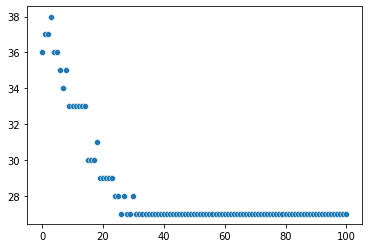

In [297]:
import seaborn as sns
sns.scatterplot(x=range(len(mlogbook.select("min"))), y=mlogbook.select("min"))

In [306]:
min_score = 1000000
best_child = []
for child in population:
    if evalCSTP(child)[0] < min_score:
        min_score = evalCSTP(child)[0]
        best_child = child

elf_jobs = {
    0: [],
    1: [],
    2: []
}

for i in range(len(best_child[0,:])):
    elf_jobs[best_child[1][i]] = elf_jobs[best_child[1][i]]+[best_child[0][i]]

In [307]:
elf_jobs

{0: [0, 22, 18, 1, 11],
 1: [25, 2, 15, 19, 12, 10, 6, 3, 20, 17, 24, 9],
 2: [16, 4, 8, 21, 26, 7, 23, 27, 14, 5, 13]}

In [308]:
find_superperm_string(elf_jobs[0]), find_superperm_string(elf_jobs[1]), find_superperm_string(elf_jobs[2])

('1234312412312431',
 '1243132413231241321342134212341',
 '3412142314231234214321243214323142')

In [309]:
'''
# my optimal ->15
print('my Optimal')
checkOutputValid(['412341243124', '124832418342134', '123842318432143'], 4)

# no wildcard ->17
print('no wild optimal')
checkOutputValid(['3124341234132413', '12431234213142314', '12341243214321342'], 4)
'''
print('Result:')
# GA result
checkOutputValid([find_superperm_string(elf_jobs[0]), 
                  find_superperm_string(elf_jobs[1]), 
                  find_superperm_string(elf_jobs[2])], 4)

Result:
Valid Output!
Lengths:  [16, 31, 34]
Score:  34


True

In [313]:
evalCSTP(hof[0])[0]

29

# n = 7

In [3]:
perms=pd.read_csv('permutations.csv')
communal = perms[perms.Permutation.str.startswith('🎅🤶')]
new_perms = perms.append(communal, ignore_index=True).append(communal, ignore_index=True)
new_perms['salesman'] = -1
new_perms

,Permutation,salesman
0,🎅🤶🦌🧝🎄🎁🎀,-1
1,🎅🤶🦌🧝🎄🎀🎁,-1
2,🎅🤶🦌🧝🎁🎄🎀,-1
3,🎅🤶🦌🧝🎁🎀🎄,-1
4,🎅🤶🦌🧝🎀🎄🎁,-1
...,...,...
5275,🎅🤶🎀🎁🦌🎄🧝,-1
5276,🎅🤶🎀🎁🧝🦌🎄,-1
5277,🎅🤶🎀🎁🧝🎄🦌,-1
5278,🎅🤶🎀🎁🎄🦌🧝,-1


In [6]:
city_df.shape

(5280, 2)

In [7]:
sm0 = list(range(120))
sm1 = list(range(5040,5160))
sm2 = list(range(5160,5280))

new_perms.salesman[city_df.index.isin(sm0)] = 0
new_perms.salesman[city_df.index.isin(sm1)] = 1
new_perms.salesman[city_df.index.isin(sm2)] = 2

/tmp/ipykernel_124939/394351850.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_perms.salesman[new_perms.index.isin(sm0)] = 0
/tmp/ipykernel_124939/394351850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_perms.salesman[new_perms.index.isin(sm1)] = 1
/tmp/ipykernel_124939/394351850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_perms.salesman[new_perms.index.isin(sm2)] = 2


In [17]:
new_perms

,Permutation,salesman
0,🎅🤶🦌🧝🎄🎁🎀,0
1,🎅🤶🦌🧝🎄🎀🎁,0
2,🎅🤶🦌🧝🎁🎄🎀,0
3,🎅🤶🦌🧝🎁🎀🎄,0
4,🎅🤶🦌🧝🎀🎄🎁,0
...,...,...
5275,🎅🤶🎀🎁🦌🎄🧝,2
5276,🎅🤶🎀🎁🧝🦌🎄,2
5277,🎅🤶🎀🎁🧝🎄🦌,2
5278,🎅🤶🎀🎁🎄🦌🧝,2


In [18]:
new_perms.groupby('salesman').count()

,Permutation
salesman,
-1,816
0,1392
1,1680
2,1392


In [19]:
loc_dict = new_perms['Permutation'].to_dict()
loc_dict

{0: '🎅🤶🦌🧝🎄🎁🎀',
 1: '🎅🤶🦌🧝🎄🎀🎁',
 2: '🎅🤶🦌🧝🎁🎄🎀',
 3: '🎅🤶🦌🧝🎁🎀🎄',
 4: '🎅🤶🦌🧝🎀🎄🎁',
 5: '🎅🤶🦌🧝🎀🎁🎄',
 6: '🎅🤶🦌🎄🧝🎁🎀',
 7: '🎅🤶🦌🎄🧝🎀🎁',
 8: '🎅🤶🦌🎄🎁🧝🎀',
 9: '🎅🤶🦌🎄🎁🎀🧝',
 10: '🎅🤶🦌🎄🎀🧝🎁',
 11: '🎅🤶🦌🎄🎀🎁🧝',
 12: '🎅🤶🦌🎁🧝🎄🎀',
 13: '🎅🤶🦌🎁🧝🎀🎄',
 14: '🎅🤶🦌🎁🎄🧝🎀',
 15: '🎅🤶🦌🎁🎄🎀🧝',
 16: '🎅🤶🦌🎁🎀🧝🎄',
 17: '🎅🤶🦌🎁🎀🎄🧝',
 18: '🎅🤶🦌🎀🧝🎄🎁',
 19: '🎅🤶🦌🎀🧝🎁🎄',
 20: '🎅🤶🦌🎀🎄🧝🎁',
 21: '🎅🤶🦌🎀🎄🎁🧝',
 22: '🎅🤶🦌🎀🎁🧝🎄',
 23: '🎅🤶🦌🎀🎁🎄🧝',
 24: '🎅🤶🧝🦌🎄🎁🎀',
 25: '🎅🤶🧝🦌🎄🎀🎁',
 26: '🎅🤶🧝🦌🎁🎄🎀',
 27: '🎅🤶🧝🦌🎁🎀🎄',
 28: '🎅🤶🧝🦌🎀🎄🎁',
 29: '🎅🤶🧝🦌🎀🎁🎄',
 30: '🎅🤶🧝🎄🦌🎁🎀',
 31: '🎅🤶🧝🎄🦌🎀🎁',
 32: '🎅🤶🧝🎄🎁🦌🎀',
 33: '🎅🤶🧝🎄🎁🎀🦌',
 34: '🎅🤶🧝🎄🎀🦌🎁',
 35: '🎅🤶🧝🎄🎀🎁🦌',
 36: '🎅🤶🧝🎁🦌🎄🎀',
 37: '🎅🤶🧝🎁🦌🎀🎄',
 38: '🎅🤶🧝🎁🎄🦌🎀',
 39: '🎅🤶🧝🎁🎄🎀🦌',
 40: '🎅🤶🧝🎁🎀🦌🎄',
 41: '🎅🤶🧝🎁🎀🎄🦌',
 42: '🎅🤶🧝🎀🦌🎄🎁',
 43: '🎅🤶🧝🎀🦌🎁🎄',
 44: '🎅🤶🧝🎀🎄🦌🎁',
 45: '🎅🤶🧝🎀🎄🎁🦌',
 46: '🎅🤶🧝🎀🎁🦌🎄',
 47: '🎅🤶🧝🎀🎁🎄🦌',
 48: '🎅🤶🎄🦌🧝🎁🎀',
 49: '🎅🤶🎄🦌🧝🎀🎁',
 50: '🎅🤶🎄🦌🎁🧝🎀',
 51: '🎅🤶🎄🦌🎁🎀🧝',
 52: '🎅🤶🎄🦌🎀🧝🎁',
 53: '🎅🤶🎄🦌🎀🎁🧝',
 54: '🎅🤶🎄🧝🦌🎁🎀',
 55: '🎅🤶🎄🧝🦌🎀🎁',
 56: '🎅🤶🎄🧝🎁🦌🎀',
 57: '🎅🤶🎄🧝🎁🎀🦌',
 58: '🎅🤶🎄🧝🎀🦌🎁',
 59: '🎅🤶🎄🧝🎀🎁🦌',
 60: '🎅🤶🎄🎁🦌🧝🎀',
 61: '🎅🤶🎄🎁🦌🎀🧝',
 62: '🎅🤶🎄🎁🧝🦌🎀',
 6

In [11]:
distance=pd.read_csv('distance_matrix.csv')
distance.set_index('Permutation',drop=True,inplace=True)
origin = '🎅🤶🦌🧝🎁🎄🎀'
dest = '🎀🎁🎄🦌🤶🎅🧝'
dist = distance[dest][origin]
print(dist)
origin+dest[-dist:]

6


'🎅🤶🦌🧝🎁🎄🎀🎁🎄🦌🤶🎅🧝'

In [16]:
test_array=[720*2-1,5,3]
print(find_superperm_string(test_array))
print(length_fitness(test_array))

🤶🎀🎁🎄🧝🦌🎅🤶🦌🧝🎀🎁🎄🎅🤶🦌🧝🎁🎀🎄
20


In [20]:
import multiprocessing
city_df = new_perms.copy()

In [21]:
city_df

,Permutation,salesman
0,🎅🤶🦌🧝🎄🎁🎀,0
1,🎅🤶🦌🧝🎄🎀🎁,0
2,🎅🤶🦌🧝🎁🎄🎀,0
3,🎅🤶🦌🧝🎁🎀🎄,0
4,🎅🤶🦌🧝🎀🎄🎁,0
...,...,...
5275,🎅🤶🎀🎁🦌🎄🧝,2
5276,🎅🤶🎀🎁🧝🦌🎄,2
5277,🎅🤶🎀🎁🧝🎄🦌,2
5278,🎅🤶🎀🎁🎄🦌🧝,2


In [33]:
def crossover(ind1, ind2):
    CROSSOVER_WINDOW = 10 #its not a window clearly... but why did he write 10???
    
    assert(len(ind1[0])==len(ind2[0])),"Mismatch in len of ind1 and ind2"
    size = len(ind1[0])
    
    cxpoint1 = random.randint(0, size-2)
    cxpoint2 = random.randint(1, size-1)
    
    if cxpoint2 >= cxpoint1:
        cxpoint2+=1 #increase by 1 incase equal
    else:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1 #swap so that 1<2
        
    ind1[0][cxpoint1:cxpoint2], ind2[0][cxpoint1:cxpoint2] = ind2[0][cxpoint1:cxpoint2].copy(), ind1[0][cxpoint1:cxpoint2].copy()
    
    ind1_dict = dict(list(zip(ind1[0], ind2[0]))[cxpoint1:cxpoint2])
    ind2_dict = dict(list(zip(ind2[0], ind1[0]))[cxpoint1:cxpoint2])
    
    if len([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][:cxpoint1]])>0:
        while max([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][:cxpoint1]]): #WTF does this do???
            for dest in ind1[0][:cxpoint1]:
                if dest in ind1[0][cxpoint1:cxpoint2]:
                    ind1[0][:cxpoint1] = np.where(ind1[0][:cxpoint1]==dest, ind1_dict[dest], ind1[0][:cxpoint1])
    

    if len([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][cxpoint2:]])>0:            
        while max([x in ind1[0][cxpoint1:cxpoint2] for x in ind1[0][cxpoint2:]]):
            for dest in ind1[0][cxpoint2:]:
                if dest in ind1[0][cxpoint1:cxpoint2]:
                    ind1[0][cxpoint2:] = np.where(ind1[0][cxpoint2:]==dest, ind1_dict[dest], ind1[0][cxpoint2:])
    
    if len([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][:cxpoint1]])>0:
        while max([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][:cxpoint1]]): #WTF does this do???
            for dest in ind2[0][:cxpoint1]:
                if dest in ind2[0][cxpoint1:cxpoint2]:
                    ind2[0][:cxpoint1] = np.where(ind2[0][:cxpoint1]==dest, ind2_dict[dest], ind2[0][:cxpoint1])
    
    if len([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][cxpoint2:]]):
        while max([x in ind2[0][cxpoint1:cxpoint2] for x in ind2[0][cxpoint2:]]):
            for dest in ind2[0][cxpoint2:]:
                if dest in ind2[0][cxpoint1:cxpoint2]:
                    ind2[0][cxpoint2:] = np.where(ind2[0][cxpoint2:]==dest, ind2_dict[dest], ind2[0][cxpoint2:])
        
    
    for i in range(size):
        city = ind1[0][i]
        
        if city_df.iloc[city]['salesman']==-1:
            #do nothing
            pass 
        elif city_df.iloc[city]['salesman']==0:
            ind1[1][i]=0
        elif city_df.iloc[city]['salesman']==1:
            ind1[1][i]=1
        else:
            ind1[1][i]=2
     

        city = ind2[0][i]
        if city_df.iloc[city]['salesman']==-1:
            #do nothing
            pass
        elif city_df.iloc[city]['salesman']==0:
            ind2[1][i]=0
        elif city_df.iloc[city]['salesman']==1:
            ind2[1][i]=1
        else:
            ind2[1][i]=2
    
    return ind1,ind2
    

def init2d(icls):
    locs = np.random.permutation(list(range(number_cities)))
    salesmen = np.random.randint(3, size=number_cities)
    '''
    DONE: fixed this function
    
    '''
    for i in range(len(locs)):
        if city_df.iloc[locs[i]]['salesman']==-1:
            continue 
        elif city_df.iloc[locs[i]]['salesman']==0:
            salesmen[i] = 0
        elif city_df.iloc[locs[i]]['salesman']==1:
            salesmen[i] = 1
        else:
            salesmen[i] = 2

    
    colorCity = np.stack((locs, salesmen))
    return icls(colorCity)

def evalCSTP(individual):
    max_len = 0
    #print(individual)
    for salesman in range(3):
        trip = individual[0][individual[1]==salesman]
        trip_len = len(find_superperm_string(trip))
        if trip_len > max_len:
            max_len = trip_len
    # if max length is worse than guessing, ensure value gets dominated 
    if max_len > GUESSING_VALUE:
        return DOMINATE_VAL,
    return max_len,

def swap_loc(individual): # Calculate some kind of rate of size of chromosome?
    for i in range(500):
        loc1 = random.randint(0,number_cities-1)
        loc2 = random.randint(0,number_cities-1)
        
        individual[0][loc1], individual[0][loc2] = individual[0][loc2], individual[0][loc1]
    
    #check swap is valid
    for i in range(len(individual[0])):
        if city_df.iloc[i]['salesman']==-1:
            return individual, 
        elif city_df.iloc[i]['salesman']==0:
            individual[1][i] = 0 
        elif city_df.iloc[i]['salesman']==1:
            individual[1][i] = 1
        else:
            individual[1][i] = 2
    return individual,


In [ ]:
GUESSING_VALUE = 15000
DOMINATE_VAL = 100000000

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", numpy.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

number_cities = len(city_df)

pool = multiprocessing.Pool()
toolbox.register('map', pool.map)

toolbox.register('individual', init2d, creator.Individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

print('initialised')

toolbox.register('evaluate', evalCSTP)
toolbox.register('mate', crossover)
toolbox.register('mutate', swap_loc)
#toolbox.register('select', tools.selNSGA2)
#toolbox.register('select', tools.selSPEA2)
toolbox.register("select", tools.selTournament, tournsize=4)
population = toolbox.population(n=50)

print('created initial population')

hof = tools.HallOfFame(1, similar=np.array_equal)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)


popul, mlogbook = algorithms.eaMuCommaLambda(
    population, toolbox, mu=50, lambda_=100, cxpb=0.6, mutpb=0.4, ngen=10000, stats=stats, halloffame=hof
)


initialised
created initial population
gen	nevals	avg    	std    	min  	max  
0  	50    	13192.4	88.7315	12954	13424
1  	100   	12683.9	167.04 	12433	13317
2  	100   	12663.9	188.546	12433	13179
3  	100   	12660.9	183.938	12434	13142
4  	100   	12680.5	189.313	12429	13137
5  	100   	12670  	193.356	12469	13163
6  	100   	12616.3	141.668	12466	13096
7  	100   	12609.5	177.624	12462	13199
8  	100   	12685.3	215.745	12449	13175
9  	100   	12695.5	199.498	12451	13183
10 	100   	12646.9	163.685	12453	13188
11 	100   	12649.7	225.536	12458	13264
12 	100   	12670.9	257.088	12448	13255
13 	100   	12652  	224.856	12442	13223
14 	100   	12635.3	245.576	12438	13260
15 	100   	12553.6	158.061	12438	13198
16 	100   	12564.6	219.811	12425	13194
17 	100   	12577.5	267.872	12403	13275
18 	100   	12609.4	274.918	12392	13189
19 	100   	12540.3	240.128	12402	13209
20 	100   	12609.5	287.426	12399	13199
21 	100   	12654.6	292.781	12419	13265
22 	100   	12645.4	270.586	12405	13265
23 	100   	12663.1	289.10

209	100   	12536.6	199.645	12436	13245
210	100   	12535.9	215.955	12431	13230
211	100   	12490.9	145.487	12412	13183
212	100   	12533.4	222.327	12414	13198
213	100   	12566  	251.347	12418	13238
214	100   	12655.6	312.926	12424	13268
215	100   	12564.2	250.65 	12431	13254
216	100   	12683.8	330.267	12439	13365
217	100   	12662.1	264.063	12441	13291
218	100   	12603.2	243.277	12454	13283
219	100   	12600.1	263.208	12447	13309
220	100   	12606.2	253.03 	12441	13237
221	100   	12616.1	231.13 	12429	13320
222	100   	12648  	272.604	12431	13264
223	100   	12534.1	158.144	12438	13224
224	100   	12564.9	255.098	12425	13296
225	100   	12587.8	264.203	12408	13312
226	100   	12676.1	340.205	12413	13317
227	100   	12542  	182.105	12427	13263
228	100   	12575.8	206.985	12412	13332
229	100   	12668.8	310.709	12433	13329
230	100   	12605.9	262.562	12426	13282
231	100   	12582.1	251.97 	12426	13237
232	100   	12558.5	224.775	12426	13214
233	100   	12610.9	298.655	12419	13230
234	100   	12726.9	360.81

In [ ]:
import seaborn as sns
sns.scatterplot(x=range(len(mlogbook.select("min"))), y=mlogbook.select("min"))

In [27]:
min_score = 1000000
best_child = []
for child in population:
    if evalCSTP(child)[0] < min_score:
        min_score = evalCSTP(child)[0]
        best_child = child

elf_jobs = {
    0: [],
    1: [],
    2: []
}

for i in range(len(best_child[0,:])):
    elf_jobs[best_child[1][i]] = elf_jobs[best_child[1][i]]+[best_child[0][i]]

In [28]:
checkOutputValid([find_superperm_string(elf_jobs[0]), 
                  find_superperm_string(elf_jobs[1]), 
                  find_superperm_string(elf_jobs[2])], 7)

Not valid - string 1 doesnt contain value  1234567


False

In [32]:
len(best_child[0])

5280